In [1]:
from IPython.display import clear_output
import SALib
clear_output()
print("Everything imported!")

Everything imported!


In [2]:
%matplotlib inline
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# OFAT SA
One Factor at A Time (OFAT or OFaaT) SA is a method of testing the output variance of inputs one at a time. 

In [3]:
# We define our variables and bounds
problem = {
        "num_vars": 5,
        "names": ["initial_cash", "initial_assets", "mutation", "std", "asset_price"],
        "bounds": [[5000, 500000], [100, 10000], [0, 1], [0, 0.1], [1, 5000]],
    }

# Experiment parameters
replicates = 50
max_steps = 730  # 2 years
distinct_samples = 2**6  # convergence property

In [4]:
asset_price = pd.read_csv('data-2/ofat/OFAT_asset_price_r50_m730_s64.csv')
initial_assets = pd.read_csv('data-2/ofat/OFAT_initial_assets_r50_m730_s64.csv')
mutation = pd.read_csv('data-2/ofat/OFAT_mutation_r50_m730_s64.csv')
std = pd.read_csv('data-2/ofat/OFAT_std_r50_m730_s64.csv')
initial_cash = pd.read_csv('data-2/ofat/OFAT_initial_cash_r50_m730_s64.csv')

In [5]:
all_pd = [initial_cash, initial_assets,mutation, std, asset_price]
names = problem['names']
data = {}
for i in range(len(names)):
    data[names[i]] = all_pd[i] 

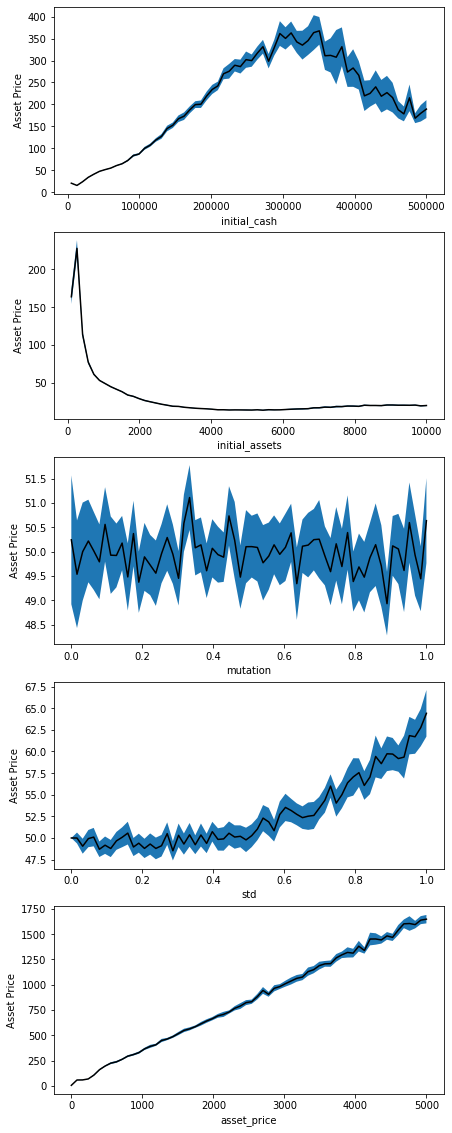

In [7]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby([f'{var}', 'iteration'])[param].mean().groupby([f'{var}']).mean()

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby([f'{var}', 'iteration'])[param].mean().groupby([f'{var}']).std()) / np.sqrt(replicates/731)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)


def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(5, figsize=(7, 20))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)
    plt.savefig('all_vars.png.')

    
plot_all_vars(data, 'Asset Price')
plt.show()


# Sobol SA

In [8]:
replicates = 50
max_steps = 730  # 2 years
distinct_samples = 2**6  # convergence property

problem = {
    "num_vars": 5,
    "names": ["initial_cash", "initial_assets", "mutation", "std", "asset_price"],
    "bounds": [[5000, 500000], [100, 10000], [0, 1], [0, 0.1], [1, 5000]],
}
param_values = saltelli.sample(problem, distinct_samples)

In [10]:
data = pd.read_csv('sobol.csv')

In [11]:
Si = sobol.analyze(problem, data['Asset Price'].values, print_to_console=True)

                      ST   ST_conf
initial_cash    0.010882  0.002097
initial_assets  0.020524  0.007206
mutation        0.018636  0.007247
std             0.025436  0.008636
asset_price     0.026710  0.009065
                      S1   S1_conf
initial_cash   -0.001658  0.008081
initial_assets  0.010640  0.018498
mutation        0.012675  0.017629
std             0.017093  0.017383
asset_price     0.013320  0.018943
                                      S2   S2_conf
(initial_cash, initial_assets)  0.061395  0.033044
(initial_cash, mutation)        0.062900  0.033266
(initial_cash, std)             0.060862  0.033227
(initial_cash, asset_price)     0.060979  0.033313
(initial_assets, mutation)      0.050704  0.037003
(initial_assets, std)           0.050448  0.037184
(initial_assets, asset_price)   0.050364  0.037103
(mutation, std)                 0.003476  0.023880
(mutation, asset_price)         0.005040  0.024102
(std, asset_price)              0.003436  0.024659


In [12]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

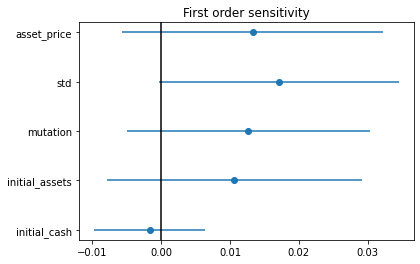

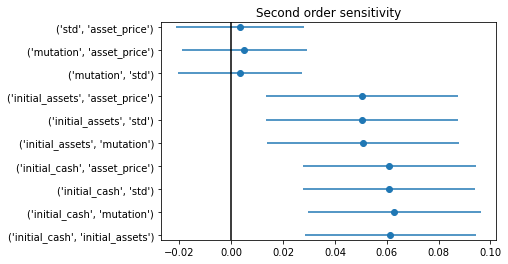

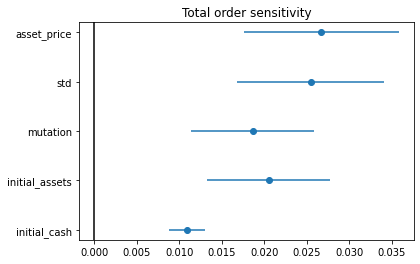

In [13]:
plot_index(Si, problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index(Si, problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
plt.show()